In [52]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def get_frames_as_matrix(video_path):
    cap = cv.VideoCapture(video_path)
    frames = []
    counter = 5
    while cap.isOpened() and counter > 0:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frames.append(frame)
        counter -= 1

    cap.release()
    return np.array(frames)

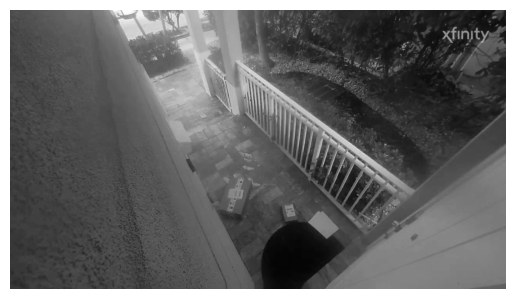

In [54]:
frames = get_frames_as_matrix("cctvfootage.mp4")
plt.imshow(frames[0], cmap='gray')
plt.axis('off')
plt.show()

In [63]:
def vectorize_matrix(frames):
    result = frames[0].T.flatten()
    for i in range(1, len(frames)):
        flattened = frames[i].T.flatten()
        result = np.hstack((result, flattened))
    return result

# for i in range(len(frames.shape[0])):
#     frames[]
# frames[0]
Y = vectorize_matrix(frames)

In [68]:
Y.shape


(10368000,)

In [65]:
objective = norm

array([102, 102, 102, ..., 117, 117, 117], dtype=uint8)

In [77]:
n = 6

fib0 = 0
fib1 = 1
n = 0
while True:
    s = str(fib1)
    if len(s) >= 1000:
        break
    temp = fib1
    fib1 = fib1 + fib0
    fib0 = temp
    n += 1


print(n)

4781
